In [1]:
import os
# point to durga GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-f80e9374-504a-571b-bac0-6fb00750db4c"
# point to nandi GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import gzip
from tqdm import tqdm
import pyBigWig
from pyfaidx import Fasta
import subprocess
import sys


model_cell_type = "K562"

timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]

in_window = 2114
out_window = 1000


# filepaths

proj_dir = "/mnt/lab_data2/kcochran/procapnet/"
genome_path = proj_dir + "genomes/hg38.withrDNA.fasta"
chrom_sizes = proj_dir + "genomes/hg38.withrDNA.chrom.sizes"
gtf_filepath = proj_dir + "annotations/gencode.v41.annotation.gtf.gz"

all_procap_peak_path = proj_dir + "data/procap/processed/" + model_cell_type + "/peaks.bed.gz"
plus_bw_path = proj_dir + "data/procap/processed/" + model_cell_type + "/5prime.pos.bigWig"
minus_bw_path = proj_dir + "data/procap/processed/" + model_cell_type + "/5prime.neg.bigWig"

model_save_paths = [proj_dir + "models/procap/" + model_cell_type + "/strand_merged_umap/" + timestamp + ".model" for timestamp in timestamps]


genes_list_path = "genes_to_screen.csv"  # from Shreya

candidate_promoter_regions_bed = "TSS_windows.merge.bed"

## Pre-processing Regions To Apply Model To

In [3]:
# load info for genes (and transcripts, for TSSs) from GENCODE GTF

def load_gtf(gtf_filepath, region_types_to_load = ["gene", "transcript"]):
    regions = defaultdict(lambda : [])
    
    if gtf_filepath.endswith(".gz"):
        f = gzip.open(gtf_filepath)
    else:
        f = open(gtf_filepath)
        
    for line in f:
        if gtf_filepath.endswith(".gz"):
            line = line.decode()
        
        if line.startswith("#"):
            continue  # skip header
        
        chrom, _, label, start, end, _, strand = line.split()[:7]

        if label in region_types_to_load:
            if label == "gene":
                gene_name = line.split()[13][1:-2]
            else:
                gene_name = line.split()[15][1:-2]  # second indexing is to remove "...";

            regions[label].append((chrom, start, end, strand, gene_name))
            
    f.close()
    return regions


gtf_regions = load_gtf(gtf_filepath)
assert len(gtf_regions) > 0, len(gtf_regions)

In [4]:
# load Shreya's gene list

def load_genes_to_screen(csv_path):
    df = pd.read_csv(csv_path, sep=",")
    return list(df["gene_name"])
    
gene_names = load_genes_to_screen(genes_list_path)

In [5]:
print(gene_names)

['MT-RNR1', 'PJA2', 'MYO15B', 'MRFAP1', 'SCAMP4', 'PLXND1', 'IPO7', 'CNOT1', 'DAZAP2', 'RN7SL1', 'CROCCP2', 'ATP6AP1', 'PPIA', 'ARAP1', 'TLN1', 'NEAT1', 'MTATP6P1', 'PRKDC', 'MTMR9LP', 'ATP5F1B', 'LENG8', 'THUMPD3-AS1', 'RCC1L', 'SRRM2', 'HNRNPF', 'MALAT1', 'LSM14A', 'CAPZA2', 'MTCO1P12', 'NCKAP1L', 'RNPS1', 'REPIN1', 'CAPNS1', 'ZNF407-AS1', 'CLTC', 'TMX2', 'GNA13', 'RBM12', 'PTMS', 'PILRA', 'ACACA', 'RAB31', 'MYO5A', 'DCTN1', 'CCNL2', 'ATXN7L3B', 'ZBTB7A', 'RANBP2', 'ARPC5', 'DENND4B', 'RHOA', 'RBM14', 'VPS52', 'G3BP1', 'SEPTIN2', 'SNX3', 'DCLRE1A', 'EP400', 'WBP2', 'EIF3A', 'TAF9', 'PFKL', 'SF1', 'JUND', 'NOL7', 'TMEM259', 'FNIP1', 'STK40', 'RAB11B', 'SET', 'ATP6V1C1', 'AGRN', 'HNRNPU', 'SF3B1', 'ARF6', 'HNRNPH1', 'HCLS1', 'CICP14', 'DOCK2', 'ZNF8', 'ILF3', 'ACADVL', 'ZNHIT3', 'TADA2A']


In [6]:
# pull genes of interest from the loaded GTF data
# for every gene, get all transcripts and their start sites
# then for every TSS, draw a window of sequence you will make predictions for


def filter_for_target_genes(gtf_regions, gene_names):
    target_regions = []
    for region in gtf_regions:
        gene_name = region[-1]
        if not (gene_name in gene_names):
            continue
        target_regions.append(region)
        
    return target_regions


def assemble_info_for_genes(gtf_regions, gene_names):
    # try loading in all genes by gene name
    target_genes_info = filter_for_target_genes(gtf_regions["gene"], gene_names)
    
    # check we find all the genes we expect (and nothing extra)
    assert set([info[-1] for info in target_genes_info]) == set(gene_names)
    
    # then load in all transcripts for those genes in the same way
    transcripts_info = filter_for_target_genes(gtf_regions["transcript"], gene_names)
    
    # simplify GTF-pulled info into just the gene name and the coordinates + strand
    genes_to_transcript_locations = defaultdict(lambda : [])
    for transcript in transcripts_info:
        gene_for_transcript = transcript[-1]
        transcript_location = transcript[:-1]
        
        genes_to_transcript_locations[gene_for_transcript].append(transcript_location)
    
    # for each transcript, process coordinates into just the 1bp TSS
    TSSs_per_gene = defaultdict(lambda : set())
    for gene_name, transcripts in genes_to_transcript_locations.items():
        for (chrom, start, end, strand) in transcripts:
            if strand == "+":
                TSS_annot = int(start)
            else:
                TSS_annot = int(end)
            
            # the -1 is to convert 1-indexed GTF coords into 0-indexed BED coords
            TSSs_per_gene[gene_name].add((chrom, TSS_annot - 1, TSS_annot, strand))
    
    # around each TSS, how large of a window to consider
    extend_by = 2000
    
    # extend windows +/- 2kb around each TSS (wide "candidate promoter region")
    TSS_windows_per_gene = defaultdict(lambda : [])
    for gene_name, TSSs in TSSs_per_gene.items():
        for chrom, start, end, strand in TSSs:
            # because we already convert into BED coords above, un-adjust by 1 here
            start = max(0, start - extend_by + 1)
            end = end + extend_by
            assert end - start == extend_by * 2 or start == 0, end - start
            
            TSS_windows_per_gene[gene_name].append((chrom, start, end, strand))
    
    return TSS_windows_per_gene
    
    
TSS_windows_per_gene = assemble_info_for_genes(gtf_regions, gene_names)

In [7]:
# save the windows we will use into a BED file
# merge overlaps to avoid redundancy (we will tile predictions across regions anyways)

def write_regions_to_bed_file(regions, filepath):
    regions = sorted(regions, key = lambda region : (region[0], int(region[1])))
    if filepath.endswith(".gz"):
        with gzip.open(filepath, "w") as f:
            for region_info in regions:
                line = "\t".join([str(thing) for thing in region_info]) + "\n"
                f.write(line.encode())
    else:
        with open(filepath, "w") as f:
            for region_info in regions:
                line = "\t".join([str(thing) for thing in region_info]) + "\n"
                f.write(line)
                
                
def run_bedtools_merge(filepath_i, dest_filepath, other_args=[]):
    cmd = ["bedtools", "merge"]
    cmd += ["-i", filepath_i]
    for arg in other_args:
        cmd += [arg]
        
    with open(dest_filepath, "w") as outf:
        subprocess.call(cmd, stdout=outf)


def write_TSS_windows_to_bed(TSS_windows):
    flattened_list = []
    for gene_name, windows in TSS_windows.items():
        # adding gene name to info to write to file
        # also need to make strand info be in the 6th column for bedtools 
        flattened_list.extend([list(w[:-1]) + [gene_name, ".", w[-1]] for w in windows])
        
    write_regions_to_bed_file(flattened_list, "TSS_windows.premerge.bed")
    run_bedtools_merge("TSS_windows.premerge.bed", candidate_promoter_regions_bed,
                       other_args=["-s", "-c", "4,5,6", "-o", "distinct,distinct,distinct"])
    
    
write_TSS_windows_to_bed(TSS_windows_per_gene)

In [10]:
! head $candidate_promoter_regions_bed

chr1	629074	635696	MTATP6P1,MTCO1P12	.	+
chr1	1018120	1022123	AGRN	.	+
chr1	1032106	1036867	AGRN	.	+
chr1	1043399	1053986	AGRN	.	+
chr1	1386713	1394716	CCNL2	.	-
chr1	1396287	1401335	CCNL2	.	-
chr1	16624386	16633109	CROCCP2	.	-
chr1	16642672	16646686	CROCCP2	.	-
chr1	16655232	16659232	CROCCP2	.	-
chr1	32238247	32243710	MTMR9LP	.	-


## Applying Model To Candidate Regions

In [ ]:
# Load in the sequences at the regions we just defined

# see bpnetlite repo for better documentation on all this loading code
# https://github.com/jmschrei/bpnet-lite

# same functionality as Kelly's usual code, but also loads chrM
# also loads in the starts and stops according to the bed file (+ widths)
# (not a standardized in-out window size for all examples)


def one_hot_encode(sequence, alphabet=['A','C','G','T'], dtype='int8', 
    desc=None, verbose=False, **kwargs):
    # Converts a string or list of characters into a one-hot encoding.
    # from bpnet-lite / Jacob
    
    # these characters will be encoded as all-zeros
    ambiguous_nucs = ["Y", "R", "W", "S", "K", "M", "D", "V", "H", "B", "X", "N"]

    d = verbose is False

    sequence = sequence.upper()
    if isinstance(sequence, str):
        sequence = list(sequence)

    alphabet = alphabet or np.unique(sequence)
    alphabet_lookup = {char: i for i, char in enumerate(alphabet)}

    ohe = np.zeros((len(sequence), len(alphabet)), dtype=dtype)
    for i, char in tqdm(enumerate(sequence), disable=d, desc=desc, **kwargs):
        if char in alphabet:
            idx = alphabet_lookup[char]
            ohe[i, idx] = 1
        else:
            assert char in ambiguous_nucs, char

    return ohe


def read_fasta_fast(filename, chrom_sizes=None, include_chroms=None, verbose=True):
    # Read in a FASTA file and output a dictionary of sequences
    # from bpnet-lite / Jacob
    
    if include_chroms is None:
        if chrom_sizes is None:
            print("Assuming human chromosomes in read_fasta_fast.")
            include_chroms = ["chr" + str(i + 1) for i in range(22)]
            include_chroms.extend(["chrX", "chrY", "chrM"])
        else:
            include_chroms = load_chrom_names(chrom_sizes)

    chroms = {}
    print("Loading genome sequence from " + filename)
    fasta_index = Fasta(filename)
    for chrom in tqdm(include_chroms, disable=not verbose, desc="Reading FASTA"):
        chroms[chrom] = fasta_index[chrom][:].seq.upper()
    return chroms


def load_sequences(genome_path, chrom_sizes, peak_path,
                  verbose=False):

    seqs = []
    in_width = in_window // 2

    assert os.path.exists(genome_path), genome_path
    sequences = read_fasta_fast(genome_path, verbose=verbose)

    names = ['chrom', 'start', 'end']
    assert os.path.exists(peak_path), peak_path
    peaks = pd.read_csv(peak_path, sep="\t", usecols=(0, 1, 2), 
        header=None, index_col=False, names=names)

    desc = "Loading Peaks"
    d = not verbose
    for _, (chrom, og_start, og_end) in tqdm(peaks.iterrows(), disable=d, desc=desc):
        # Append sequence to growing sequence list
        
        # get sequence from fasta for this chromosome
        chrom_sequence = sequences[chrom]
        
        # determine beginning and end of region (extend out by model input width)
        s = max(0, og_start - in_width)
        e = og_end + in_width
        assert s >= 0, s

        if isinstance(chrom_sequence, str):
            seq = one_hot_encode(chrom_sequence[s:e]).T
        else:
            seq = chrom_sequence[s:e].T

        assert seq.shape == (4, e - s), (seq.shape, s, e)
        assert set(seq.flatten()) == set([0,1]), set(seq.flatten())
        # the following asserts allow for [0,0,0,0] as a valid base encoding
        assert set(seq.sum(axis=0)).issubset(set([0, 1])), set(seq.sum(axis=0))
        assert seq.sum() <= e - s, seq
        seqs.append(seq)
        
    to_print = "\nPeak filepath: " + peak_path
    to_print += "\nNum. examples loaded: " + str(len(seqs))
    print(to_print)
    sys.stdout.flush()

    return seqs

onehot_seqs = load_sequences(genome_path, chrom_sizes, candidate_promoter_regions_bed)

In [ ]:
def load_data(plus_bw_path, minus_bw_path, peak_path,
                       verbose=False):

    signals = []
    out_width = out_window // 2

    names = ['chrom', 'start', 'end']
    assert os.path.exists(peak_path), peak_path
    peaks = pd.read_csv(peak_path, sep="\t", usecols=(0, 1, 2), 
        header=None, index_col=False, names=names)

    assert os.path.exists(plus_bw_path), plus_bw_path
    assert os.path.exists(minus_bw_path), minus_bw_path
    plus_bw = pyBigWig.open(plus_bw_path, "r")
    minus_bw = pyBigWig.open(minus_bw_path, "r")

    desc = "Loading Peaks"
    d = not verbose
    for _, (chrom, og_start, og_end) in tqdm(peaks.iterrows(), disable=d, desc=desc):
        start = max(0, og_start - out_width)
        end = og_end + out_width
        assert start >= 0, start

        # Load plus strand signal
        plus_sig = plus_bw.values(chrom, start, end, numpy=True)
        plus_sig = np.nan_to_num(plus_sig)

        # Load minus strand signal
        minus_sig = minus_bw.values(chrom, start, end, numpy=True)
        minus_sig = np.nan_to_num(minus_sig)

        # Append signal to growing signal list
        assert len(plus_sig) == end - start, (len(plus_sig), start, end)
        assert len(minus_sig) == end - start, (len(minus_sig), start, end)
        signals.append(np.array([plus_sig, minus_sig]))
    
    to_print += "\nPeak filepath: " + peak_path
    to_print += "\nNum. examples loaded: " + str(len(signals))
    print(to_print)
    sys.stdout.flush()

    return signals


true_profs = load_data(plus_bw_path, minus_bw_path, candidate_promoter_regions_bed)

In [ ]:
# might need to deal with the chrM gene separately because it had to be loaded weirdly
# (too close to end of chromosome)

In [13]:
import torch
import matplotlib.pyplot as plt

In [18]:
sys.path.append("../2_train_models")
from BPNet_strand_merged_umap import Model

def load_model(model_save_path):
    model = torch.load(model_save_path)
    model = model.eval()
    return model

models = [load_model(model_save_path) for model_save_path in model_save_paths]

## Generate Predictions

In [30]:
# for each candidate promoter region:
# chunk sequence into all possible contiguous 2114bp tiles (that's the model input size)
# make a prediction for each chunk
# put predictions into giant numpy array of nans, tiled like sequence was
# take nanmean (overlapping predictions averaged appropriately)

def model_predict_with_rc(model, onehot_seq):
    model = model.cuda()
    with torch.no_grad():
        onehot_seq = onehot_seq[None, ...].cuda()
        pred_profiles, pred_logcounts = model.predict(onehot_seq)
        rc_pred_profiles, rc_pred_logcounts = model.predict(torch.flip(onehot_seq, [-1, -2]))
    
    model = model.cpu()
    
    # reverse-complement (strand-flip) BOTH of the predictions
    rc_pred_profiles = rc_pred_profiles[:, ::-1, ::-1]
    rc_pred_logcounts = rc_pred_logcounts[:, ::-1]
    
    # take the average prediction across the fwd and RC sequences
    merged_pred_profiles = np.log(np.array([np.exp(pred_profiles), np.exp(rc_pred_profiles)]).mean(axis=0))
    merged_pred_logcounts = np.array([pred_logcounts, rc_pred_logcounts]).mean(axis=0)
    
    return merged_pred_profiles, merged_pred_logcounts


def predict_one_seq(onehot_seq, models, skip = 50):
    onehot_seq = torch.Tensor(onehot_seq).float()
    assert len(onehot_seq.shape) == 2 and onehot_seq.shape[0] == 4, onehot_seq.shape
    
    num_seq_tiles = int(np.ceil((onehot_seq.shape[-1] - in_window) / skip + 1))
    
    preds_all = np.empty((num_seq_tiles, 2, onehot_seq.shape[-1] - (in_window - out_window)))
    preds_all[:] = np.nan
    
    tiles_to_do = list(skip * np.arange(0, num_seq_tiles - 1))
    # if not a nice even number of tiles to do vs. skips, tack on last window
    if tiles_to_do[-1] != onehot_seq.shape[1] - in_window:
        tiles_to_do.append(onehot_seq.shape[1] - in_window)

    assert len(tiles_to_do) == num_seq_tiles, (len(tiles_to_do), num_seq_tiles)
        
    with torch.no_grad():
        for tile_i, tile_i_skip in enumerate(tiles_to_do):
            assert tile_i_skip + in_window <= onehot_seq.shape[1], (tile_i_skip + in_window, onehot_seq.shape[1])
            seq_tile = onehot_seq[:, tile_i_skip : tile_i_skip + in_window]
            
            pred_profs_across_models = []
            pred_logcounts_across_models = []
            for model in models:
                pred_prof, pred_logcounts = model_predict_with_rc(model, seq_tile)
                pred_profs_across_models.append(pred_prof)
                pred_logcounts_across_models.append(pred_logcounts)
            
            pred_prof_avg_across_models = np.mean(np.exp(np.array(pred_profs_across_models)), axis=0)
            pred_counts_avg_across_models = np.exp(np.mean(np.array(pred_logcounts_across_models), axis=0))
            
            pred_prof_scaled = (pred_prof_avg_across_models * pred_counts_avg_across_models).squeeze()

            assert preds_all[tile_i, :, tile_i_skip : pred_prof_scaled.shape[-1] + tile_i_skip].shape == pred_prof_scaled.shape, (preds_all[tile_i, tile_i_skip : pred_prof_scaled.shape[-1] + tile_i_skip].shape, pred_prof_scaled.shape)
            preds_all[tile_i, :, tile_i_skip : pred_prof_scaled.shape[-1] + tile_i_skip] = pred_prof_scaled
    
    preds_final = np.nanmean(preds_all, axis=0)
    return preds_final


def predict_all_seqs_all_models(onehot_seqs, models):
    return [predict_one_seq(seq, models) for seq in tqdm(onehot_seqs)]


all_preds = predict_all_seqs_all_models(onehot_seqs, models)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [2:28:07<00:00, 38.98s/it]


In [50]:
# old
def predict_one_seq_old(onehot_seq, model, skip = 50):
    onehot_seq = torch.Tensor(onehot_seq).float()
    assert len(onehot_seq.shape) == 2 and onehot_seq.shape[0] == 4, onehot_seq.shape
    
    #num_seq_tiles = onehot_seq.shape[1] - in_window + 1
    num_seq_tiles = int(np.ceil((onehot_seq.shape[1] - in_window) / skip + 1))
    
    preds_all = np.empty((num_seq_tiles, 2, out_window + num_seq_tiles - 1))
    preds_all[:] = np.nan

    with torch.no_grad():
        for tile_i in range(num_seq_tiles):
            assert tile_i + in_window <= onehot_seq.shape[1], (tile_i + in_window, onehot_seq.shape[1])
            seq_tile = onehot_seq[:, tile_i : tile_i + in_window]
            
            pred_prof, pred_logcounts = model(seq_tile[None, ...].cuda())
            
            pred_prof_scaled = (np.exp(pred_prof.cpu().numpy()) * np.exp(pred_logcounts.cpu().numpy())).squeeze()

            assert preds_all[tile_i, :, tile_i : pred_prof_scaled.shape[-1] + tile_i].shape == pred_prof_scaled.shape, (preds_all[tile_i, tile_i : pred_prof_scaled.shape[-1] + tile_i].shape, pred_prof_scaled.shape)
            preds_all[tile_i, :, tile_i : pred_prof_scaled.shape[-1] + tile_i] = pred_prof_scaled
    
    preds_final = np.nanmean(preds_all, axis=0)
    return preds_final


def predict_all_seqs(onehot_seqs, model):
    return [predict_one_seq_old(seq, model.cuda()) for seq in onehot_seqs]


all_preds_old = predict_all_seqs(onehot_seqs[:100], models[0])

In [33]:
# save model predictions as a dump of lots of little numpy files
# (not ideal)

tmp_save_dir = "preds_npys_v2/"

os.makedirs(tmp_save_dir, exist_ok=True)

for pred_i, pred in enumerate(all_preds):
    np.save(tmp_save_dir + str(pred_i) + ".npy", pred)

In [98]:
pred_obs_corr = np.corrcoef(np.log(all_pred_counts + 1), np.log(all_true_profs + 1))[0,1]

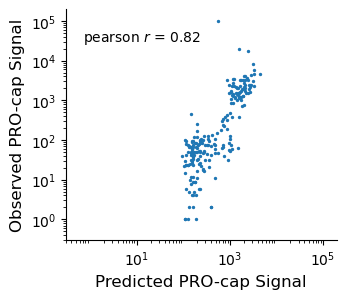

In [101]:
from matplotlib.ticker import LogLocator

plt.figure(figsize=(3.5,3))
plt.scatter(all_pred_counts, all_true_profs, s=2)
plt.xlabel("Predicted PRO-cap Signal", fontsize=12)
plt.ylabel("Observed PRO-cap Signal", fontsize=12)
plt.semilogx()
plt.semilogy()
plt.xlim(0.3, 10**5.3)
plt.ylim(0.3, 10**5.3)
plt.gca().xaxis.set_minor_locator(LogLocator(numticks=999, subs="auto"))
plt.gca().spines[["top", "right"]].set_visible(False)

plt.text(0.7, 10**4.5, r'pearson $r$ = ' + "%0.2f" % (pred_obs_corr))
plt.show()

In [76]:
# save the model predictions as a genome-wide bigwig
# (overlapping predictions will be averaged)

# edited from Kelly's usual code to allow for ragged sequence length input


def load_chrom_names(chrom_sizes, filter_out = ["_", "Un", "EBV"], filter_in = ["chr"]):
    with open(chrom_sizes) as f:
        lines = f.readlines()
    lines = [line.strip().split() for line in lines]
    chroms = [line[0] for line in lines]
    
    if filter_out and len(filter_out) > 0:
        chroms = [c for c in chroms if all([filt not in c for filt in filter_out])]
    if filter_in and len(filter_in) > 0:
        chroms = [c for c in chroms if all([filt in c for filt in filter_in])]
    return chroms


def load_chrom_sizes(chrom_sizes_filepath):
    with open(chrom_sizes_filepath) as f:
        chrom_sizes_lines = [line.strip().split('\t') for line in f]
        chrom_sizes = [(line[0], int(line[1])) for line in chrom_sizes_lines]
    return chrom_sizes


def load_coords_ragged(peaks_file):
    lines = []
    if peaks_file.endswith(".gz"):
        with gzip.open(peaks_file) as f:
            lines = [line.decode().split()[:3] for line in f]
    else:
        with open(peaks_file) as f:
            lines = [line.split()[:3] for line in f]
            
    coords = []
    for line in lines:
        chrom, start, end = line[0], int(line[1]), int(line[2])
        peak_len = end - start
        preds_len = peak_len + out_window
        mid = start + (end - start) // 2
        # last coord is calculated weird because of odd-length windows
        coord = (chrom, mid - preds_len // 2, mid - preds_len // 2 + preds_len)
        if coord[1] < 0:
            coord = (chrom, 0 + (in_window - out_window) // 2, mid - preds_len // 2 + preds_len)
        coords.append(coord)

    return coords


def make_track_values_dict(all_values, coords, chrom):
    track_values = defaultdict(lambda : [])

    for values, (coord_chrom, start, end) in zip(all_values, coords):
        # subset to only peaks/values for the chromosome we're looking at now
        if coord_chrom == chrom:
            assert len(values) == end - start, (len(values), start, end, end - start)
            
            for position, value in enumerate(values):
                position_offset = position + start
                track_values[position_offset] = track_values[position_offset] + [value]
    
    # take the mean at each position, so that if there was ovelap, the average value is used
    track_values = { key : sum(vals) / len(vals) for key, vals in track_values.items() }
    return track_values


def write_tracks_to_bigwigs(values,
                            peaks_file,
                            save_filepath_prefix,
                            chrom_sizes_filepath):
    
    print("Writing predicted profiles to bigwigs.")
    print("Peaks: " + peaks_file)
    print("Save prefix: " + save_filepath_prefix)
    print("Chrom sizes file: " + chrom_sizes_filepath)
    
    coords = load_coords_ragged(peaks_file)
    assert len(coords) == len(values)
    
    for strand_idx, strand in enumerate(["+", "-"]):
        # write separate bigwigs for svalues on the forward vs. reverse strands (in case of overlap)
        if strand == "+":
            bw_filename = save_filepath_prefix + ".pos.bigWig"
        else:
            bw_filename = save_filepath_prefix + ".neg.bigWig"
        
        values_for_strand = [vals[strand_idx] for vals in values]
            
        # bigwigs need to be written in order -- so we have to go chromosome by chromosome,
        # and the chromosomes need to be numerically sorted (i.e. chr9 then chr10)
        chrom_names = load_chrom_names(chrom_sizes_filepath)
        chrom_order = {chrom : i for i, chrom in enumerate(chrom_names)}
        chromosomes = sorted(list({coord[0] for coord in coords}),
                             key = lambda chrom_str : chrom_order[chrom_str])
            
        bw = pyBigWig.open(bw_filename, 'w')
        # bigwigs need headers before they can be written to
        # the header is just the info you'd find in a chrom.sizes file
        bw.addHeader(load_chrom_sizes(chrom_sizes_filepath))
        
        for chrom in chromosomes:
            # convert arrays of scores for each peak into dict of base position : score
            # this function will average together scores at the same position from different called peaks
            track_values_dict = make_track_values_dict(values_for_strand, coords, chrom)
            num_entries = len(track_values_dict)
            
            starts = sorted(list(track_values_dict.keys()))
            ends = [position + 1 for position in starts]
            values_to_write = [track_values_dict[key] for key in starts]
            
            assert len(values_to_write) == len(starts) and len(values_to_write) == len(ends)
            
            bw.addEntries([chrom for _ in range(num_entries)], 
                           starts, ends = ends, values = values_to_write)
    
        bw.close()


write_tracks_to_bigwigs(all_preds, candidate_promoter_regions_bed,
                        "tracks_v2/TSS_windows.preds", chrom_sizes)

Writing predicted profiles to bigwigs.
Peaks: TSS_windows.merge.bed
Save prefix: tracks_v2/TSS_windows.preds
Chrom sizes file: /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.chrom.sizes


## Sequence-Interpretation Scoring

In [ ]:
# repeat same process as model prediction, but this time score sequence instead
# since this step takes forever, we will do 1 2114bp tile every 50bp (50x speedup)

In [78]:
# functions we need in order to run deepshap

# Code borrowed, modified from Jacob Schreiber
# https://github.com/jmschrei/bpnet-lite/blob/master/bpnetlite/attributions.py

import numba
import torch

@numba.jit('void(int64, int64[:], int64[:], int32[:, :], int32[:,], int32[:, :], float32[:, :, :])')
def _fast_shuffle(n_shuffles, chars, idxs, next_idxs, next_idxs_counts, counters, shuffled_sequences):
    """An internal function for fast shuffling using numba."""

    for i in range(n_shuffles):
        for char in chars:
            n = next_idxs_counts[char]

            next_idxs_ = np.arange(n)
            next_idxs_[:-1] = np.random.permutation(n-1)  # Keep last index same
            next_idxs[char, :n] = next_idxs[char, :n][next_idxs_]

        idx = 0
        shuffled_sequences[i, idxs[idx], 0] = 1
        for j in range(1, len(idxs)):
            char = idxs[idx]
            count = counters[i, char]
            idx = next_idxs[char, count]

            counters[i, char] += 1
            shuffled_sequences[i, idxs[idx], j] = 1


def dinuc_shuffle(sequence, n_shuffles=10, random_state=None):
    if not isinstance(random_state, np.random.RandomState):
        random_state = np.random.RandomState(random_state)

    chars, idxs = torch.unique(sequence.argmax(axis=0), return_inverse=True)
    chars, idxs = chars.numpy(), idxs.numpy()

    next_idxs = np.zeros((len(chars), sequence.shape[1]), dtype=np.int32)
    next_idxs_counts = np.zeros(max(chars)+1, dtype=np.int32)

    for char in chars:
        next_idxs_ = np.where(idxs[:-1] == char)[0]
        n = len(next_idxs_)

        next_idxs[char][:n] = next_idxs_ + 1
        next_idxs_counts[char] = n

    shuffled_sequences = np.zeros((n_shuffles, *sequence.shape), dtype=np.float32)
    counters = np.zeros((n_shuffles, len(chars)), dtype=np.int32)

    _fast_shuffle(n_shuffles, chars, idxs, next_idxs, next_idxs_counts, 
        counters, shuffled_sequences)

    shuffled_sequences = torch.from_numpy(shuffled_sequences)
    return shuffled_sequences


class ProfileModelWrapper(torch.nn.Module):
    # this wrapper assumes:
    # 1) the model's profile head outputs pre-softmax logits
    # 2) the profile output has the last axis as the profile-length dimension
    # 3) the softmax should be applied over both strands at the same time
    #      (a ala Jacob's bpnetlite implementation of BPNet)
    # 4) the profile head is the first of two model outputs
    
    def __init__(self, model):
        super(ProfileModelWrapper, self).__init__()
        self.model = model
        
    def forward(self, X):
        logits, _ = self.model(X)
        logits = logits.reshape(logits.shape[0], -1)
        mean_norm_logits = logits - torch.mean(logits, axis = -1, keepdims = True)
        softmax_probs = torch.nn.Softmax(dim=-1)(mean_norm_logits.detach())
        return (mean_norm_logits * softmax_probs).sum(axis=-1)
    
    
class CountsModelWrapper(torch.nn.Module):
    # this wrapper assumes the counts head is the second of two model outputs
    
    def __init__(self, model):
        super(CountsModelWrapper, self).__init__()
        self.model = model
        
    def forward(self, X):
        _, logcounts = self.model(X)
        return logcounts

In [86]:
from captum.attr import DeepLiftShap

prof_shap_explainers = [DeepLiftShap(ProfileModelWrapper(model.cuda())) for model in models]
counts_shap_explainers = [DeepLiftShap(CountsModelWrapper(model.cuda())) for model in models]

In [90]:
def deepshap_once(seq):
    assert len(seq.shape) == 3

    ref_seqs = dinuc_shuffle(seq[0], 20).float().cuda()
    
    prof_attrs = []
    count_attrs = []
    prof_attrs_rc = []
    count_attrs_rc = []
    
    for prof_explainer, counts_explainer in zip(prof_shap_explainers, counts_shap_explainers):
        prof_attrs.append(prof_explainer.attribute(seq.cuda(), ref_seqs).cpu().detach().numpy())
        count_attrs.append(counts_explainer.attribute(seq.cuda(), ref_seqs).cpu().detach().numpy())
        
        prof_attrs_rc.append(prof_explainer.attribute(torch.flip(seq, [1,2]).cuda(),
                                                      torch.flip(ref_seqs, [1,2])).cpu().detach().numpy())
        count_attrs_rc.append(counts_explainer.attribute(torch.flip(seq, [1,2]).cuda(),
                                                      torch.flip(ref_seqs, [1,2])).cpu().detach().numpy())
    
    prof_attrs = np.mean(np.array(prof_attrs), axis=0)
    count_attrs = np.mean(np.array(count_attrs), axis=0)
    
    prof_attrs_rc = np.mean(np.array(prof_attrs_rc), axis=0)
    count_attrs_rc = np.mean(np.array(count_attrs_rc), axis=0)
    
    prof_attrs = np.mean(np.array([prof_attrs, prof_attrs_rc[..., ::-1, ::-1]]), axis=0)
    count_attrs = np.mean(np.array([count_attrs, count_attrs_rc[..., ::-1, ::-1]]), axis=0)
    
    prof_attrs = prof_attrs * seq.numpy()
    count_attrs = count_attrs * seq.numpy()
    
    return prof_attrs.squeeze(), count_attrs.squeeze()


def deepshap_one_seq(onehot_seq, skip = 100):
    onehot_seq = torch.Tensor(onehot_seq).float()
    assert len(onehot_seq.shape) == 2 and onehot_seq.shape[0] == 4, onehot_seq.shape
    num_seq_tiles = int(np.ceil((onehot_seq.shape[1] - in_window) / skip + 1))
    
    scores_all_prof = np.empty((num_seq_tiles, 4, onehot_seq.shape[1]))
    scores_all_prof[:] = np.nan
    
    scores_all_counts = np.empty((num_seq_tiles, 4, onehot_seq.shape[1]))
    scores_all_counts[:] = np.nan

    tiles_to_do = list(skip * np.arange(0, num_seq_tiles - 1))
    # if not a nice even number of tiles to do vs. skips, tack on last window
    if tiles_to_do[-1] != onehot_seq.shape[1] - in_window:
        tiles_to_do.append(onehot_seq.shape[1] - in_window)
    
    assert len(tiles_to_do) == num_seq_tiles, (len(tiles_to_do), num_seq_tiles)
        
    for tile_i, tile_i_skip in enumerate(tiles_to_do):
        assert tile_i_skip + in_window <= onehot_seq.shape[1], (tile_i_skip + in_window, onehot_seq.shape[1])
        seq_tile = onehot_seq[:, tile_i_skip : tile_i_skip + in_window]

        prof_attrs, count_attrs = deepshap_once(seq_tile[None, ...])

        assert scores_all_prof[tile_i, :, tile_i_skip : prof_attrs.shape[-1] + tile_i_skip].shape == prof_attrs.shape, (scores_all_prof[tile_i, tile_i_skip : prof_attrs.shape[-1] + tile_i_skip].shape, prof_attrs.shape)
        
        scores_all_prof[tile_i, :, tile_i_skip : prof_attrs.shape[-1] + tile_i_skip] = prof_attrs
        scores_all_counts[tile_i, :, tile_i_skip : count_attrs.shape[-1] + tile_i_skip] = count_attrs
    
    scores_final_prof = np.nanmean(scores_all_prof, axis=0)
    scores_final_counts = np.nanmean(scores_all_counts, axis=0)
    return scores_final_prof, scores_final_counts


def deepshap_all_seqs(onehot_seqs):
    all_scores_prof = []
    all_scores_counts = []
    for seq in tqdm(onehot_seqs):
        scores_prof, scores_counts = deepshap_one_seq(seq)
        all_scores_prof.append(scores_prof)
        all_scores_counts.append(scores_counts)
    return all_scores_prof, all_scores_counts


prof_scores, counts_scores = deepshap_all_seqs(onehot_seqs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [112:57:39<00:00, 1783.59s/it]


In [92]:
# save model predictions as a dump of lots of little numpy files
# (not ideal)

tmp_save_dir = "attrs_npys/"

os.makedirs(tmp_save_dir, exist_ok=True)

for attr_i, attrs in enumerate(prof_scores):
    np.save(tmp_save_dir + "prof_" + str(attr_i) + ".npy", attrs)
    
for attr_i, attrs in enumerate(counts_scores):
    np.save(tmp_save_dir + "counts_" + str(attr_i) + ".npy", attrs)

In [102]:
# save scores to bigwigs too

def load_coords_ragged_for_scores(peaks_file):
    lines = []
    if peaks_file.endswith(".gz"):
        with gzip.open(peaks_file) as f:
            lines = [line.decode().split()[:3] for line in f]
    else:
        with open(peaks_file) as f:
            lines = [line.split()[:3] for line in f]
            
    coords = []
    for line in lines:
        chrom, start, end = line[0], int(line[1]), int(line[2])
        coord = (chrom, start - in_window // 2, end + in_window // 2)
        if coord[1] < 0:
            coord = (chrom, 0, end + in_window // 2)
        coords.append(coord)

    return coords

def write_scores_to_bigwigs(scores,
                            peaks_file,
                            save_filepath,
                            chrom_sizes_filepath):
    
    # need to flatten scores after one-hot
    assert np.sum(np.sum(scores[0] == 0, axis=0) >= 3) == scores[0].shape[-1], np.sum(np.sum(scores[0] == 0, axis=0) >= 3)
    scores = [scores_one_ex.sum(axis=0) for scores_one_ex in scores]
    
    coords = load_coords_ragged_for_scores(peaks_file)
    assert len(coords) == len(scores)
    
    if not (save_filepath.endswith(".bigWig") or save_filepath.endswith(".bw")):
        bw_filename = save_filepath + ".bigWig"
    else:
        bw_filename = save_filepath
          
    print("Writing attributions to bigwig.")
    print("Peaks: " + peaks_file)
    print("Save path: " + bw_filename)
    print("Chrom sizes file: " + chrom_sizes_filepath)

    # bigwigs need to be written in order -- so we have to go chromosome by chromosome,
    # and the chromosomes need to be numerically sorted (i.e. chr9 then chr10)
    chrom_names = load_chrom_names(chrom_sizes_filepath)
    chrom_order = {chrom : i for i, chrom in enumerate(chrom_names)}
    chromosomes = sorted(list({coord[0] for coord in coords}),
                         key = lambda chrom_str : chrom_order[chrom_str])

    bw = pyBigWig.open(bw_filename, 'w')
    # bigwigs need headers before they can be written to
    # the header is just the info you'd find in a chrom.sizes file
    bw.addHeader(load_chrom_sizes(chrom_sizes_filepath))

    for chrom in chromosomes:
        # convert arrays of scores for each peak into dict of base position : score
        # this function will average together scores at the same position from different called peaks
        track_values_dict = make_track_values_dict(scores, coords, chrom)
        num_entries = len(track_values_dict)

        starts = sorted(list(track_values_dict.keys()))
        ends = [position + 1 for position in starts]
        scores_to_write = [track_values_dict[key] for key in starts]

        assert len(scores_to_write) == len(starts) and len(scores_to_write) == len(ends)

        bw.addEntries([chrom for _ in range(num_entries)], 
                       starts, ends = ends, values = scores_to_write)

    bw.close()

write_scores_to_bigwigs(prof_scores, candidate_promoter_regions_bed,
                        "tracks_v2/TSS_windows.scores.prof.bigWig", chrom_sizes)

Writing attributions to bigwig.
Peaks: TSS_windows.merge.bed
Save path: tracks_v2/TSS_windows.scores.prof.bigWig
Chrom sizes file: /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.chrom.sizes


In [103]:
write_scores_to_bigwigs(counts_scores, candidate_promoter_regions_bed,
                        "tracks_v2/TSS_windows.scores.counts.bigWig", chrom_sizes)

Writing attributions to bigwig.
Peaks: TSS_windows.merge.bed
Save path: tracks_v2/TSS_windows.scores.counts.bigWig
Chrom sizes file: /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.chrom.sizes
